# hathi_v2 Notes


Using Pyganalytics: 
https://github.com/chrpr/pyganalytics

Note: I adjusted the delimiters used in the `analytics.py` because page paths in Google Analytics contain everything under the sun and I needed to amend to try and find something that would be unique enough to work as a field separator that Pandas can recognize. However, this also means that you have to use the Python parsing engine when reading the CSV into Pandas, but given that this is a one-time operation I think the tradeoff here of doing less surgery on the analytics CSVs is worth the potential slowdown here.

I also edited the `analytics.py` script to run daily instead of weekly in order to try and capture more granular results.

Re-running the analytics scrape: 
```
python analytics.py -o /Users/joshhadro/Dropbox/NYPL/analytics/hathitrust/pt_profile/2016_01_01-2016_12_31.csv -c ~/Dropbox/NYPL/research_books/investigations/hathi/hathi_config.yml -f 2016-01-01 -l 2016-12-31
```


Scrape the analytics using something like this: 

```bash 
for i in {3..6}; do time python analytics.py -o ~/Dropbox/NYPL/research_books/investigations/hathi/v2/data/uniqueEvents_201$i\_01_01-201$i\_12_31.csv -c ~/Dropbox/NYPL/research_books/investigations/hathi/v2/hathi_events_config.yml -f 201$i-01-01 -l 201$i-12-31; done
```




Notes: 
- these tended to run between 30-60 minutes for each quarter on my machine, via a wireless connection
- Broken into annual quarters just to keep file sizes more manageable and prevent less data loss if API errored out mid-file
- this uses Google Analytics API v3, not v4 which is current, so may break sooner or later Set up an API key as described in the readme
- There is a 10000 API call per profile ID for the Google Analytics API; as a result, I had to run this over the course of 3 days.
- Dask install via `pip install dask[dataframe]` won't work in zsh for some reason, case you use that

---

    Important note: there is sampling happening in the analytics
    A ton of stuff is getting grouped together under "(other)"
    Potentially up to like 60-70% of urls
    I think the sampling is good, and should give a directional idea of trends, etc.
    But really, the analytics should be fixed before drawing final conclusions
    
Also very odd: there are results with zero pageviews
TO account for this, I might try to grab only the URLs with event triggers, and see if that's comparable? 



Process notes: 
- in the step where I ran the list of IDs and counts against the Hathifiles postgres, I lost 48392 IDs, not sure why

## Next things to fix

- DONE UC $ barcode issue -- are there other IDs that changed? 
- DONE There's an identifier type I didn't account for -- `miun.ajb1571.0001.001`
- DONE Also this one: `yul.11394676_000_00`
- Data viz of monographs vs. serials

In [1]:
import pandas as pd
import dask.dataframe as dd #USE `pip install dask[dataframe]` (does not work in zsh for some reason)
from dask.diagnostics import ProgressBar

pbar = ProgressBar()
pbar.register()

In [ ]:
# #To extract all possible search queries from the analytics

# def queries():
#     #This will extract 
#     #Note: this extract only the first match of the pattern in the source string, but for our purposes this should be both fine and correct
#     pattern = '(?P<Query>q1=[^\&\n\|]*|lookfor=[^\&\n\|]*)'
#     t = df['ga:pagePath'].str.extract(pattern, expand=True)
#     df_queries = t[t['Query'].notnull()]
#     df_queries.to_csv('./csv/queries.csv', index=False)
# # %time queries()

In [9]:
def extract_ids(): 
    
    '''
    Uses Dask to extracts HathiTrust IDs from the raw analytics logs and writes them to a series of CSVs
    '''

    
    df = dd.read_csv('./data/uniqueEvents_201*.csv', delimiter='\|\~', engine='python')
    
    
    #Note: this extract only the first match of the pattern in the source string, 
    #but for our purposes this should be both fine and correct
    
    #Pattern here is attempting to match Hathi IDs of the form 'emu.010001066661' and 'uiuo.ark:/13960/t3hx62320' 
    #pattern = '(?P<ID>([0-9a-z]{3,5}\.ark\:\/[0-9]{4,5}\/[0-9a-z$]*)|([a-z0-9]{2,}\.[a-z0-9$]{5,}([^/hathitrust.org/|?&])))'
    
    #[0-9a-z]{3,5}\.ark\:\/[0-9]{4,5}\/[0-9a-z$]*|[a-z0-9]{2,}\.[a-z0-9$]{5,}[^|?&;,]
    
    
    #Above pattern is too complicated, and actually misses titles of the form 'umn.31951d00014607r'
    #Trying something simpler instead, at the cost having to excise 'id=' from every line post-facto
    
    #pattern = '(id=[^\&\n\|;]*)'
    
    #Trying again: 
    #pattern = '(?:id=|[a-z0-9]\/)([0-9a-z]{3,5}\.ark\:\/[0-9]{4,5}\/[0-9a-z$]*|[a-z0-9]{2,}\.[a-z0-9$]{5,}[^|?&;,])'
    
    #Pattern supplied by Angelina:
    #pattern = '([a-z][a-z0-9]{1,3}\.\$?[a-z0-9._:\/]+)'
    
    #Mix of patter supplied by Angelina and me:
    pattern = '(?:id=|[a-z0-9]\/)([a-z][a-z0-9]{1,3}\.\$?[a-z0-9._:\/\-]+)'
    
    #Extract the ID matches into a new column   
    df['id'] = df['ga:pagePath'].str.extract(pattern, expand=False)
    
    #Limit to just rows with ID matches
    df = df[df['id'].notnull()]

    #Remove rows that have 'skin=crms'
    df = df[df['ga:pagePath'].str.contains('skin=crms') == False]
    
#     #Remove 'id=' from the results
#     df['id'] = df['id'].str.replace('id=', '')
    
    #Remove some junk punctuation from the end of some IDs
    df['id'] = df['id'].str.rstrip('._#')
        
    #Write the results to csvs
    df.to_csv('./data/all_ids_*.csv', index=False)
    
#This takes roughly 26min to run

%time extract_ids()

[########################################] | 100% Completed | 25min 24.7s
CPU times: user 23min 23s, sys: 5min 11s, total: 28min 34s
Wall time: 25min 25s


In [ ]:
# def ids_counts(): 
#     '''
#     Uses output csvs of extract_ids() function to create a tuple of volume IDs paired with pageview counts 
#     (either unique or aggregate pageview counts depending on how analytics were scraped) 
#     and writes them to a CSV
#     '''
#     pbar = ProgressBar()
#     pbar.register()

#     df = dd.read_csv('./data/all_ids_*.csv')
    
#     counts = {}
    
#     for index, row in df.iterrows():
#         if row['ID'] in counts:
#             counts[row['ID']] += row['count']
#         else:
#             counts[row['ID']] = row['count']
            
#     sort = pd.DataFrame.from_dict(counts, orient='index')

#     sort.index.name = 'id'
#     sort.columns = ['count']
#     sort.sort_values('count', ascending=False).to_csv('./csv/all_counts_sorted.csv')

# #This took about 4 hours to complete;
# #%time ids_counts()

In [11]:
## A much faster (~60x) way to aggregate and sort the counts of hits and associate them with Hathi IDs 

def ids_count(): 
    #Read in all the files with the extracted IDs and their counts
    df = dd.read_csv('./data/all_ids_*.csv')
    
    #Group that data by volume identifier, and then record the sum total of all hit counts
    ids = df.groupby(by=['id'])['count'].sum()
    
    #Turn dask dataframe into pandas dataframe so we can use sort_values (not implemented yet in dask)
    ids = ids.compute()    
    
    #Do some column naming, and then export to a CSV
    ids.index.name = 'id'
    ids.columns = ['count']
    ids = ids.sort_values(ascending=False).to_csv('./csv/all_counts_sorted.csv', header=True)

%time ids_count()

[########################################] | 100% Completed | 11min 31.6s
CPU times: user 11min 3s, sys: 1min 24s, total: 12min 27s
Wall time: 11min 42s


In [12]:
'''
Need to Fix UC $ issue, and roll up the total counts so they're only counted as single items with all hits.
There's some ugly pandas in here, could certainly be more effficient but it's quick enough 
that I'm calling it done for now
'''

def fix_dollar_sign_ids():

    #Need numpy briefly to do the conditional check later using .where() method
    import numpy as np
    
    #Import the extracted IDs and counts
    df = pd.read_csv('./csv/all_counts_sorted.csv')
    
    #New dataframe of just the potentially affected dollar sign IDs
    dollars = df[df['id'].str.contains('\$')]

    #New column with the id version minus dollar sign
    dollars.loc[:,'fixed_id'] = dollars['id'].str.replace('$','')
    
    #Merge with original data to get access to all counts we need to sum
    merged = df.merge(dollars, left_on='id', right_on='fixed_id', suffixes=['_df','_dollars'])

    #Sum the hit counts for the dollar sign IDs and the non dollar sign IDs
    merged.loc[:,'total'] = merged['count_df'] + merged['count_dollars']

    #Merge the totals with the original dataset again, but in a new df just to be careful
    df2 = df.merge(merged, how='outer', left_on='id', right_on='id_dollars')
    
    #Update the original 'count' column to the holistic total where needed
    df2.loc[:, 'count'] = np.where(df2['total'].notnull() == True, df2['total'], df['count'])
    
    #Remove the non-dollar sign IDs from the df, since the dollar-sign-id totals now reflect the holistic sum
    #Also removes the now extraneous extra columns
    df2 = df2[df2['id'].isin(df2['id_df']) == False][['id','count']]
    
    #Write it all out to a new csv
    df2.sort_values('count', ascending=False).to_csv('./csv/all_counts_sorted_dollar_fixed.csv')
%time fix_dollar_sign_ids()

/Users/joshhadro/Dropbox/NYPL/research_books/venv/lib/python2.7/site-packages/pandas/core/indexing.py:297: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/joshhadro/Dropbox/NYPL/research_books/venv/lib/python2.7/site-packages/pandas/core/indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


CPU times: user 24.8 s, sys: 5.17 s, total: 30 s
Wall time: 32 s


In [ ]:
zeroes = counts[counts['count'] ==0]
print "Total: %s" % len(counts)
print "Zeroes: %s" % len(zeroes)
print "Non-zero: %s" % (len(counts) - len(zeroes))

zeroes = counts_alt[counts_alt['count'] ==0]
print "Total: %s" % len(counts_alt)
print "Zeroes: %s" % len(zeroes)
print "Non-zero: %s" % (len(counts_alt) - len(zeroes))



In [ ]:
hathi.shape

In [ ]:
hathi.head()

In [13]:
#This cell does require ones step not included here which is adding the header row to the txt file with the column names

#Import the Hathifiles into a postgres database

import sqlalchemy as sa

#Struggled for a long time with this, but turns out the delimiter needs to be r'\t', not just '\t'
hathi_data = pd.read_csv('./data/hathifiles/hathi_full_20171101.txt', engine='python', delimiter=r'\t', encoding='utf-8', chunksize=1000000)


def connect(user, password, db, host='localhost', port=5432):
    '''Returns a connection and a metadata object'''
    # We connect with the help of the PostgreSQL URL
    url = 'postgresql://{}:{}@{}:{}/{}'
    url = url.format(user, password, host, port, db)

    # The return value of create_engine() is our connection object
    con = sa.create_engine(url, client_encoding='utf8')

    # We then bind the connection to MetaData()
    meta = sa.MetaData(bind=con).reflect()

    return con, meta

con, meta = connect('postgres', '', 'hathifiles')

def postgres_import():
    i = 0
    for chunk in hathi_data:
        chunk = chunk[['id','access','rights','hathitrust_record_number','enumeration_chronology','source','source_institution_record_number','oclc_numbers','isbns','issns','lccns','title','imprint','rights_determination_reason_code','date_of_last_update','government_document','publication_date','publication_place','language','bibliographic_format','collection_code','content_provider_code','responsible_entity_code','digitization_agent_code']]
        try:
            chunk.to_sql('hathifiles', con, if_exists='append')
            print i, chunk.index[0]
            i += 1
        except:
            print chunk.index[0]
#%time postgres_import()

In [ ]:
def get_access_and_date():

    gf = pd.read_csv('./csv/all_counts_sorted_dollar_fixed.csv')

    gf['access'] = ''
    gf['date'] = ''
    gf['title'] = ''
    gf['oclc'] = ''
#     gf['format'] = ''
#     gf['pub_place'] = ''
    print len(gf)

    header = 'id,title,access,date,oclc'
    text_file = open("./csv/all_id_title_access_date_oclc.csv", "w")
    text_file.write(header+'\n')
    text_file.close()
    
    for i in range(0,len(gf),250000):
        xf = gf[i:(i+250000)]
        ids = []
        for index, row in xf.iterrows():
            ids.append(row['id'])
        x = pd.read_sql_query("select id, title, access, publication_date, oclc_numbers \
                                from hathifiles where id in"+str(tuple(ids)), con=con)
        x.to_csv('./csv/all_id_title_access_date_oclc.csv', mode='a', encoding='utf-8', header=False, index=False)
        if i % 10000 == 0:
            print i

#This takes about 15min            
%time get_access_and_date()

5570514
0
250000
500000
750000
1000000
1250000


In [5]:
counts = pd.read_csv('./csv/all_counts_sorted.csv')
d_counts = pd.read_csv('./csv/all_counts_sorted_dollar_fixed.csv')
full = pd.read_csv('./csv/all_id_title_access_date_oclc.csv')

In [13]:
cs = set(counts['id'])
ds = set(d_counts['id'])
fs = set(full['id'])

In [15]:
print("barcodes fixed: %s" % (len(cs - ds)))

diff = ds - fs

for d in diff: 
    if "uc1" not in d:
        print d
    else:
        pass
            

barcodes fixed: 23863
loc.ark:/13960/t4sj23nlj
mdl.reflections.000461
loc.rbc/rbnawsa.n2748
kero.htm
uc2.ark:/13960
mdp.39015040826813
pt.id:mdp.39015051174947
oyp.33433066661673
ucl.b4164139:view
mdp.39015040826912
mdp.39015079105444-1453734647
mdp.39013999346109
mdl.reflections.mhs03165
mdp.39013999315249
mdp.39015087085455
coo.31924032664173:view1up:seq
mdp.39014003016989
wu.890662919985
mdp.39015005860161l
mdp.39099999999999
prev.89.6.861.22100
mdp.39013999345819
mdp.39015087085307
aja.1000680106
mdp.39013998980019
mdp.39015040826805
piee.1973.0244
inyp.33
mdp.39015039331312.pdf
cn.11/63
uio.ark:/13960/t9v11xq3s
coo1.ark
loc.ark:/13960
mdp.39015055248622
mdp.39015077310806
mdp.39015040826888
mdl.reflections.mhs7508-all
mdp.39013999315729
inu.skin


In [6]:
allow = full[full.access == 'allow']
deny = full[full.access == 'deny']

In [7]:
all_years = full[(full.date > 1599) & (full.date < 2018)].groupby('date')['id'].count()
allow_years = allow[(allow.date > 1599) & (allow.date < 2018)].groupby('date')['id'].count()
deny_years = deny[(deny.date > 1599) & (deny.date < 2018)].groupby('date')['id'].count()

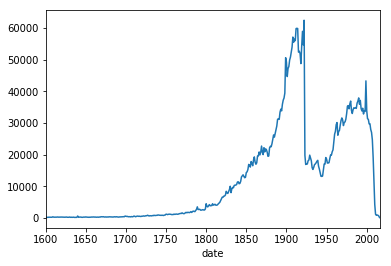

In [8]:
%matplotlib inline
all_years.plot()
#allow_years.plot()
#deny_years.plot()

In [44]:
ongoing = full[(full.date == 9999)].groupby('date')['id'].count()
ongoing_a = full[(full.date == 9999) & (full.access == 'allow')].groupby('date')['id'].count()
ongoing_d = full[(full.date == 9999) & (full.access == 'deny')].groupby('date')['id'].count()

In [45]:
print ongoing
print ongoing_a
print ongoing_d

date
9999.0    190515
Name: id, dtype: int64
date
9999.0    89453
Name: id, dtype: int64
date
9999.0    101062
Name: id, dtype: int64


In [19]:
counts_ids = full.merge(counts, on='id', suffixes=['_full','_counts'])

In [20]:
counts_ids.sort_values('count', ascending=False)

,id,title,access,date,oclc,count
105597,mdp.39015054061430,"Quicksand, by Nella Larsen.",allow,1928.0,7332881,94545
75333,mdp.39015011274175,"The surnames of Scotland, their origin meaning...",allow,1962.0,1724215,67699
65631,mdp.39015004111095,Godey's magazine.,allow,1850.0,2133694,51958
173050,pst.000057937434,The human figure / by John H. Vanderpoel.,allow,1907.0,3095972,47544
61369,mdp.39015000804453,Perfume and flavor materials of natural origin.,allow,1960.0,1493297,47097
111475,mdp.39015064340733,"Solid mensuration, by Willis F. Kern and James...",allow,1934.0,823935,43710
71155,mdp.39015008158415,Quintus Curtius [History of Alexander] with an...,allow,1946.0,685637,37191
61121,mdp.39015000566789,"America is in the heart, a personal history, b...",allow,1946.0,326807,35166
189235,uc1.32106007458745,History of wages in the United States from Col...,allow,1934.0,2794726,33232
221719,uiug.30112101024682,A short guide to New Zealand.,allow,1943.0,937704,29567


In [19]:
all_dates = x = pd.read_sql_query("SELECT DISTINCT publication_date, count(publication_date) \
           from hathifiles GROUP BY publication_date ORDER BY publication_date ASC", con=con)
all_dates_a = x = pd.read_sql_query("SELECT DISTINCT publication_date, count(publication_date) \
           from hathifiles WHERE access = 'allow' GROUP BY publication_date ORDER BY publication_date ASC", con=con)

In [25]:
dates = all_dates[(all_dates.publication_date < 2021) & (all_dates.publication_date > 1599)]
#dates_a = all_dates_a[(all_dates_a.publication_date < 2018) & (all_dates_a.publication_date > 1599)]
all_dates.publication_date

0         0188
1       1000.0
2       1002.0
3       1005.0
4       1006.0
5       1014.0
6         1029
7       1029.0
8       1030.0
9       1031.0
10      1032.0
11      1033.0
12      1035.0
13       104.0
14      1040.0
15      1049.0
16      1051.0
17      1052.0
18      1053.0
19      1054.0
20      1055.0
21      1057.0
22      1060.0
23      1061.0
24      1062.0
25        1063
26      1066.0
27      1067.0
28      1068.0
29      1069.0
         ...  
1382     987.0
1383      9902
1384    9962.0
1385    9972.0
1386    9973.0
1387    9987.0
1388     999.0
1389    9990.0
1390    9994.0
1391      9999
1392    9999.0
1393       ag 
1394       bo 
1395       bu 
1396       cl 
1397       enk
1398       fr 
1399       it 
1400       kz 
1401       li 
1402       nyu
1403       pl 
1404       ru 
1405       sp 
1406       stk
1407       ua 
1408       un 
1409       xx 
1410       xxc
1411      None
Name: publication_date, Length: 1412, dtype: object

In [56]:
#dates.index = dates.publication_date
dates_a.index = dates_a.publication_date
#dates.loc[:,'accessed'] = all_years
dates_a.loc[:,'accessed'] = allow_years
dates_a

,publication_date,count,accessed
publication_date,,,
1600.0,1600.0,295,233
1601.0,1601.0,232,168
1602.0,1602.0,278,206
1603.0,1603.0,233,192
1604.0,1604.0,296,237
1605.0,1605.0,351,233
1606.0,1606.0,322,255
1607.0,1607.0,258,211
1608.0,1608.0,296,221


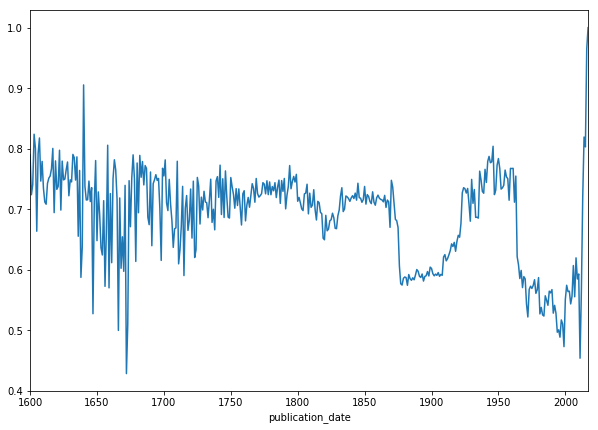

In [57]:
#util = dates.accessed / dates['count']
util_a = dates_a.accessed / dates_a['count']
util_a
#util.plot()
util_a.plot(figsize=(10,7))

In [2]:
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(allow_years, color='b')
ax1.set_ylabel('# of works', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
ax2.plot(util_a, color='r')
ax2.set_ylabel('% utilized', color='r')
ax2.tick_params('y', colors='r')
ax2.set_ylim([0,1])

NameError: name 'allow_years' is not defined

In [9]:
%matplotlib inline
pdata = pd.DataFrame()

In [10]:
pdata.loc[:, 'all'] = all_years 
pdata.loc[:, 'accessed'] = allow_years
pdata.loc[:, 'denied'] = deny_years

In [11]:
pdata['all'] = pdata['all'].astype(float)
#pdata.to_csv('./csv/all_years_data.csv')

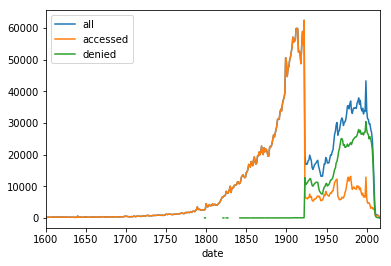

In [12]:
pdata.plot()